In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   
#from Models import *
import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [3]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)


(69, 57, 75)


In [4]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [5]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [6]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol1.shape)
NewVol = np.zeros((25, 25, 25))
NewVol[:9, :9, :9] = Vol1[3:12 , 3:12 , 3:12]
Vol1 = NewVol#[4:18,4:18,4:18 ]
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
NewVol = np.zeros((25, 25, 25))
NewVol[16:, 16:, 16:] = Vol2[3:12 , 3:12 , 3:12]
Vol2 = NewVol#[2:16,2:16,2:16 ]
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(15, 15, 15)
43
(15, 15, 15)
43


In [7]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [8]:
#Here we create Vol1 orthogonal to Vol2
"""
import copy 
print(Vol2.shape)
vecVol2 = Vol2.reshape(-1, order = 'F')
print(vecVol2.shape)
vecVol1 = copy.deepcopy(vecVol2)
for i in range(3375 - 1):
    if i % 2 == 0:
        vecVol1[i] = - vecVol2[i + 1]
    else:
        vecVol1[i] = vecVol2[i - 1]
vecVol1[-1] = 0
print(np.sum(vecVol1*vecVol2))
print(vecVol2[1500:1506])
print(vecVol1[1500:1506])
Vol1 = vecVol1.reshape(15, 15, 15 , order = 'F')
"""


"\nimport copy \nprint(Vol2.shape)\nvecVol2 = Vol2.reshape(-1, order = 'F')\nprint(vecVol2.shape)\nvecVol1 = copy.deepcopy(vecVol2)\nfor i in range(3375 - 1):\n    if i % 2 == 0:\n        vecVol1[i] = - vecVol2[i + 1]\n    else:\n        vecVol1[i] = vecVol2[i - 1]\nvecVol1[-1] = 0\nprint(np.sum(vecVol1*vecVol2))\nprint(vecVol2[1500:1506])\nprint(vecVol1[1500:1506])\nVol1 = vecVol1.reshape(15, 15, 15 , order = 'F')\n"

In [9]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.01772237


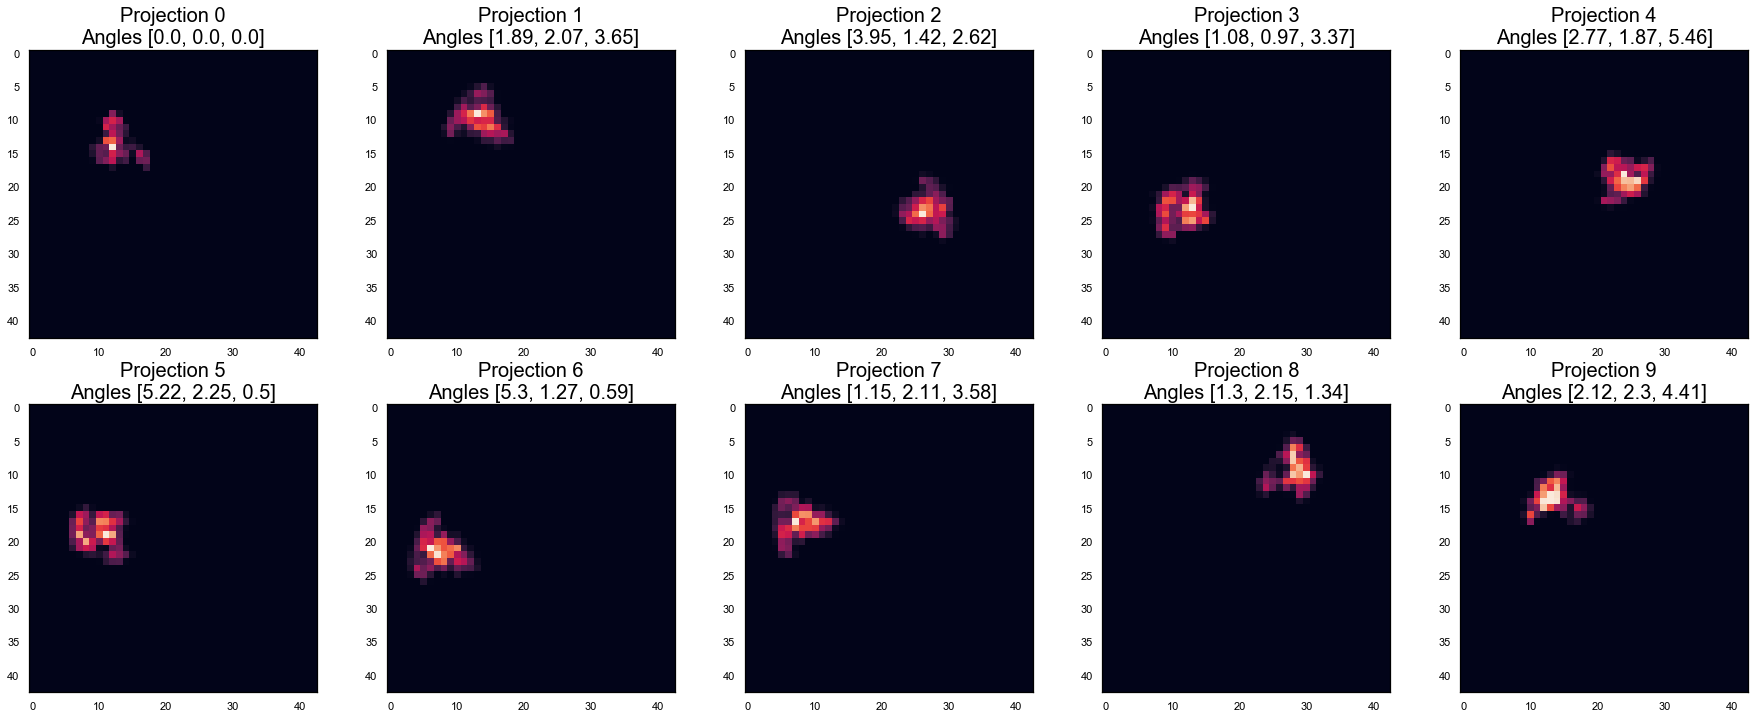

0.075168595


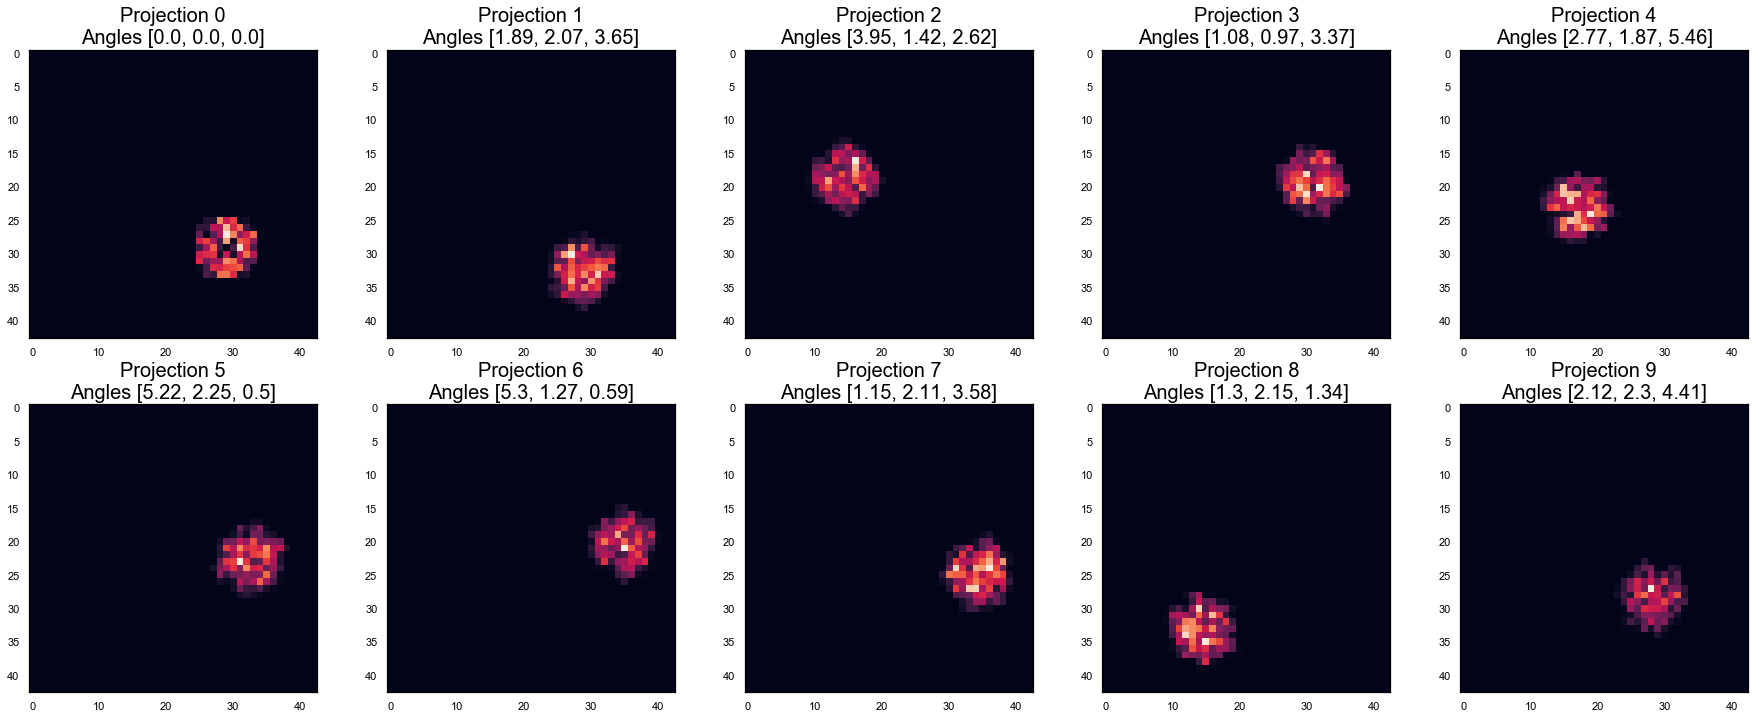

In [10]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [11]:
#BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [12]:
#print(BP_data.shape)
##print(BP_data[0].shape)
#print(Projections[0].shape)
#print(np.sum(BP_data[0] - Projections[0]))

In [13]:
#CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
#pids = range(10)
#plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.01772237


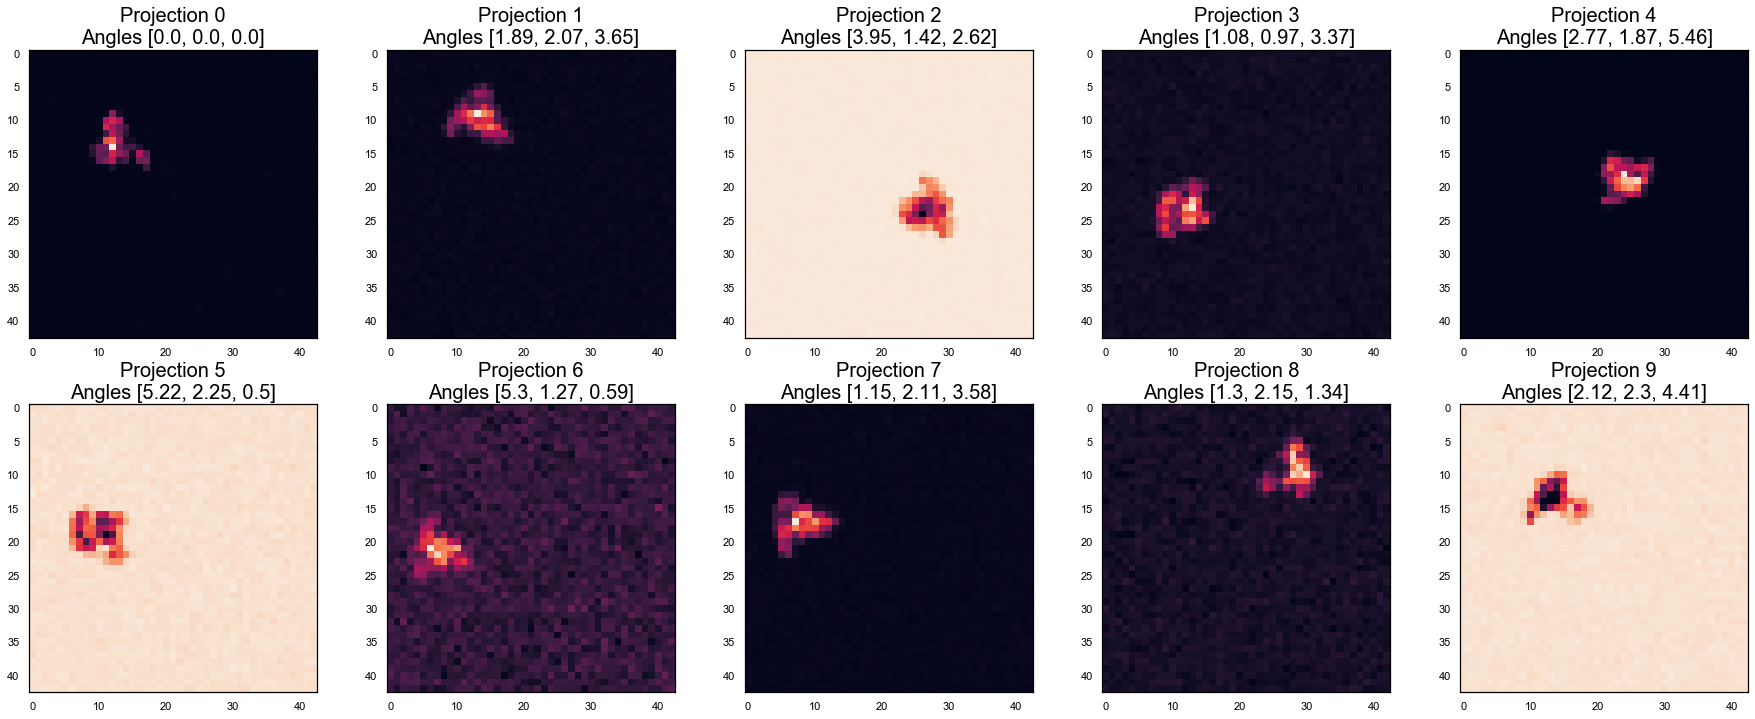

0.075168595


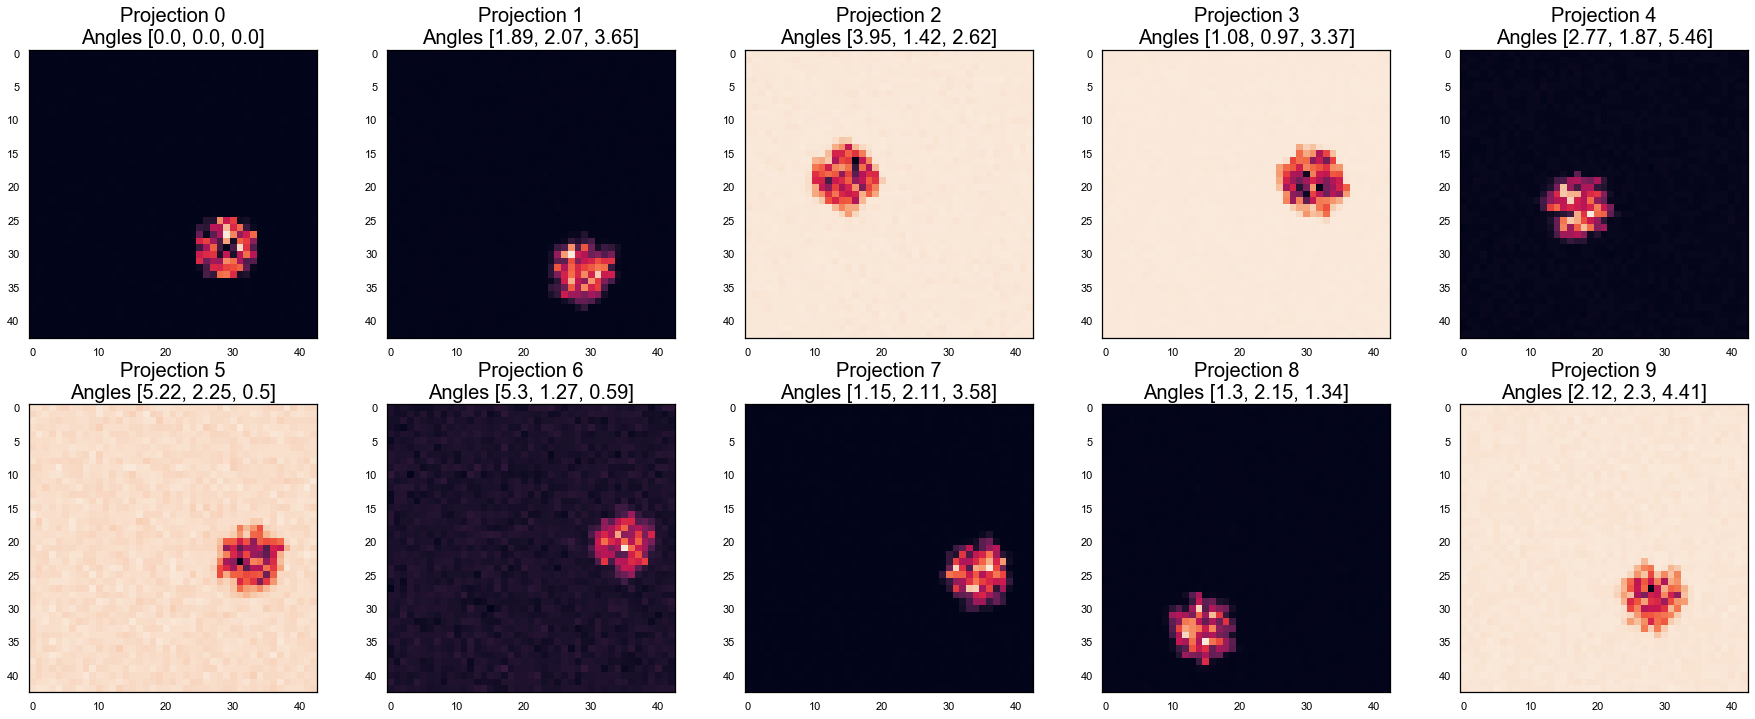

In [14]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [15]:
new_projection = Projections2 + Projections1

In [16]:
#Write a recurssive function
#Input Found mu_1, ..., mu_n-1, now_n, n_components, 

class PCA_3d_Recon_recurssive():
    def __init__(self, ProjSize, num_image, n_component, Mus = None):
        
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component

        #if Mus == None:
        ##    #This means that we are at the first iteration
        #    self.Now_n = 1
        #else:
        #We want to find the +1 component
        self.Now_n = Mus.shape[0] + 1
        
        self.Mus = np.zeros((self.Now_n, ProjSize, ProjSize, ProjSize)) + 0.00001
        self.Mus[: self.Now_n -1  , :, :, :] = Mus #Record the previous conponents
        self.sigma = np.ones(self.num_image) * 0.1


        self.ro = np.abs(np.ones((num_image, self.Now_n)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.Now_n, self.Now_n )))

        self.Aus = np.zeros(( num_image, ProjSize* ProjSize,  self.Now_n))

    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Q_(Imgages, Angles)
        self.Plot_mu_by_projection(Angles)
        for i in range(160 * 50):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
                self.Q_(Imgages, Angles)
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        for n in range(self.Now_n):
            Projections = generate_projections_ASTRA(self.Mus[n] , Angles, self.ProjSize, BatchSizeAstra = "None")
            #print(Projections.shape)
            #check_image = Projections[0].reshape(-1, 1, order = 'F')
            self.Aus[:, :, n] =  Projections.reshape(Projections.shape[0], -1 , order = 'F') #with fortrain - like order
            #print('check_Aus', check_image)
   
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        #self.Au_s(Angles)
        #ro = [] #For n image, we have n z.
        ro = np.zeros((self.num_image, self.Now_n ))
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            #ro.append(roj.tolist())
            ro[j] = roj.reshape(-1)
        #self.ro = np.array(ro).reshape(-1, self.Now_n) #Check@@@@@@@@@@
        self.ro = ro
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.Now_n, self.Now_n ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.Now_n) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.Now_n , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])

    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.Now_n):
                right_term += right_term + self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]
                #print((self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]).shape)
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.Now_n-1]
            #print('left_term', np.mean(left_term))
            #print(' self.ro[j][self.Now_n-1]' , self.ro[j][self.Now_n-1])
            temp = left_term - right_term.reshape(-1,1 , order = 'F')
            #print('left, right', np.mean(left_term), np.mean(right_term) )
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print('DeltaMu', np.mean(DeltaMu))
        #Before returning this ,since we should make the grident direction orthogonal to the previous directions, we should make
        #it orthogonal to the spam of mus
        PDeltaMu = DeltaMu.reshape(-1,1, order ='F')
        
        OriDeltaMu =  DeltaMu.reshape(-1,1, order ='F')
        Vec_Mus = self.Mus.reshape(self.Now_n, -1, 1, order = 'F')
        for i in range(self.Now_n -1):
            #print('Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu',(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu).shape)
            #print((Vec_Mus[i]*(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu)).shape)
            #print(PDeltaMu.shape)
            PDeltaMu = PDeltaMu - Vec_Mus[i]*(Vec_Mus[i].T @ OriDeltaMu / (np.linalg.norm(Vec_Mus[i]) **2))
        
        
        #print('check projected direction orthogonal mu[0]', np.sum(Vec_Mus[0] *PDeltaMu ))
        return PDeltaMu.reshape(self.ProjSize, self.ProjSize, self.ProjSize , order ='F')

    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(np.abs(self.Mus[self.Now_n -1])))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.Mus[self.Now_n -1] ) / np.mean(DeltaMu) )*0.001
            #print('lr', lr)
            self.Mus[self.Now_n -1] = self.Mus[self.Now_n -1] + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] @ self.ro[j].reshape(self.Now_n , 1)
            
            #right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            right = 0
            for x in range(self.Now_n):
                for y in range(self.Now_n):
                   right = right + self.Aus[j][: , x].T @ self.Aus[j][: , y] * self.BigSigma[j][x][y]
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        for n in range(self.Now_n):
            curremt_mu = self.Mus[n].reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
            CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
            pids = range(10)
            plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)

    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Aus[j][: ,self.Now_n - 1].reshape(-1, 1, order = 'F') * self.ro[j][self.Now_n - 1]

            #Aju =  self.Aus[j]
            #right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            right = 0
            for i in range(self.Now_n -1):
                right = right + self.Aus[j][:, i].T @ self.Aus[j][:, i] * self.BigSigma[j][i][self.Now_n - 1]
            right = right + 1/2 *  self.Aus[j][:, self.Now_n - 1].T @ self.Aus[j][:, self.Now_n - 1] * self.BigSigma[j][self.Now_n -1][self.Now_n -1]

            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass



class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))

        self.Aus = np.zeros((n_component, num_image, ProjSize* ProjSize, 1))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(250):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
              
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
        self.Au_s(Angles)
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
   
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


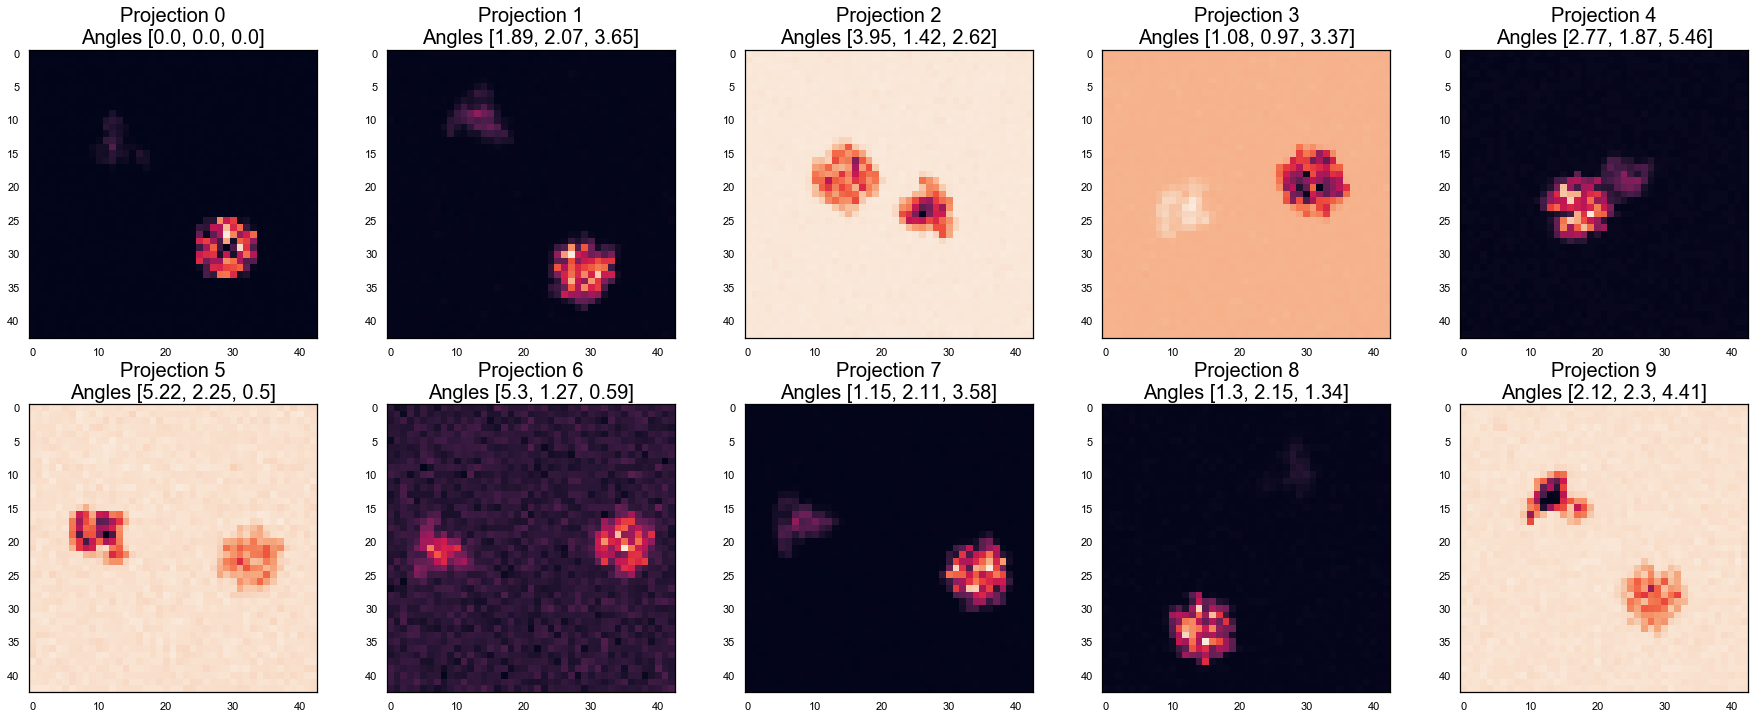

start fitting
The 0-th iteration


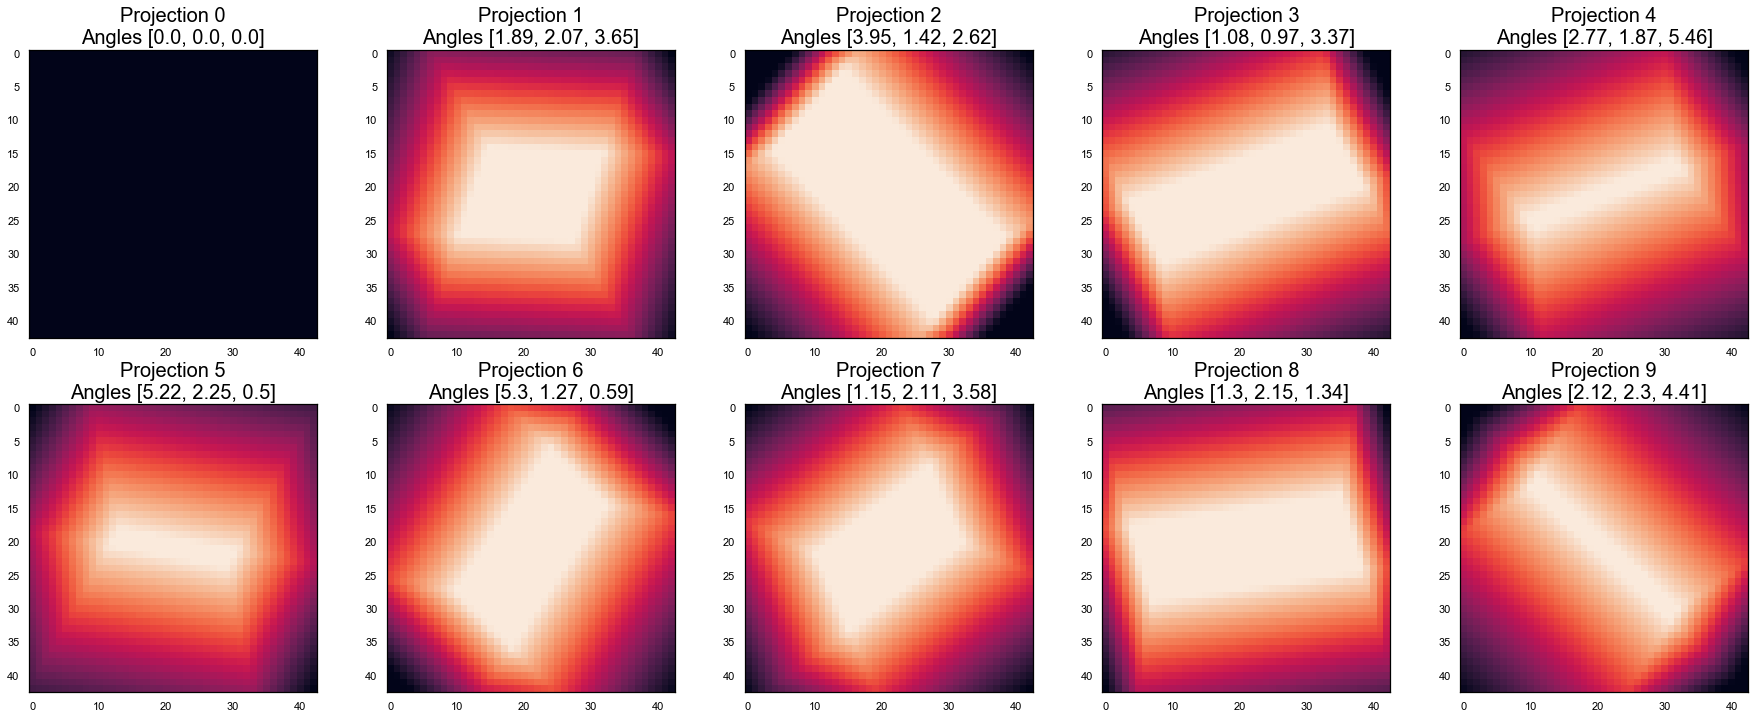

The 1-th iteration


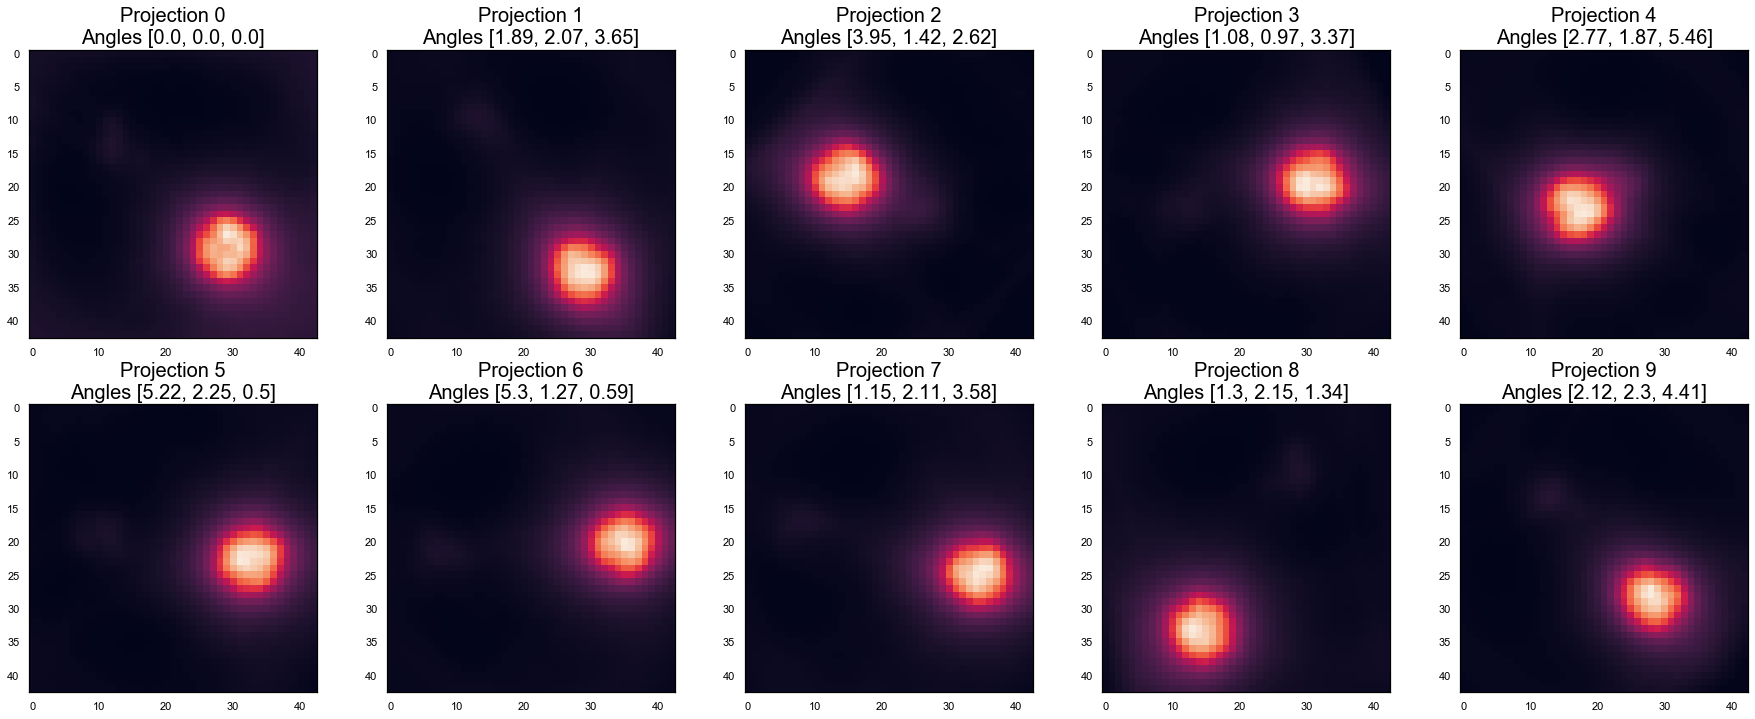

The 51-th iteration


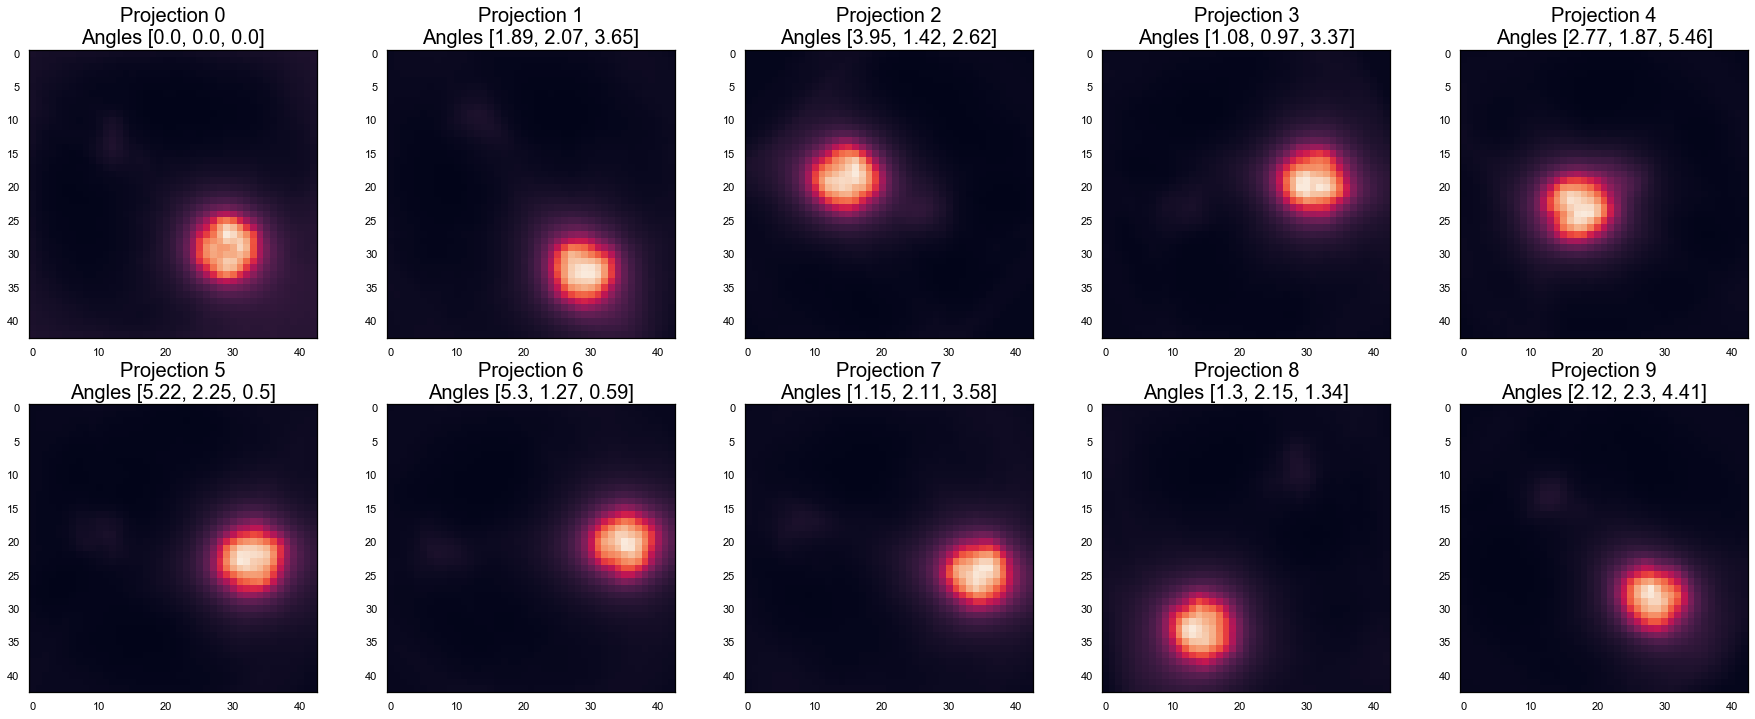

The 101-th iteration


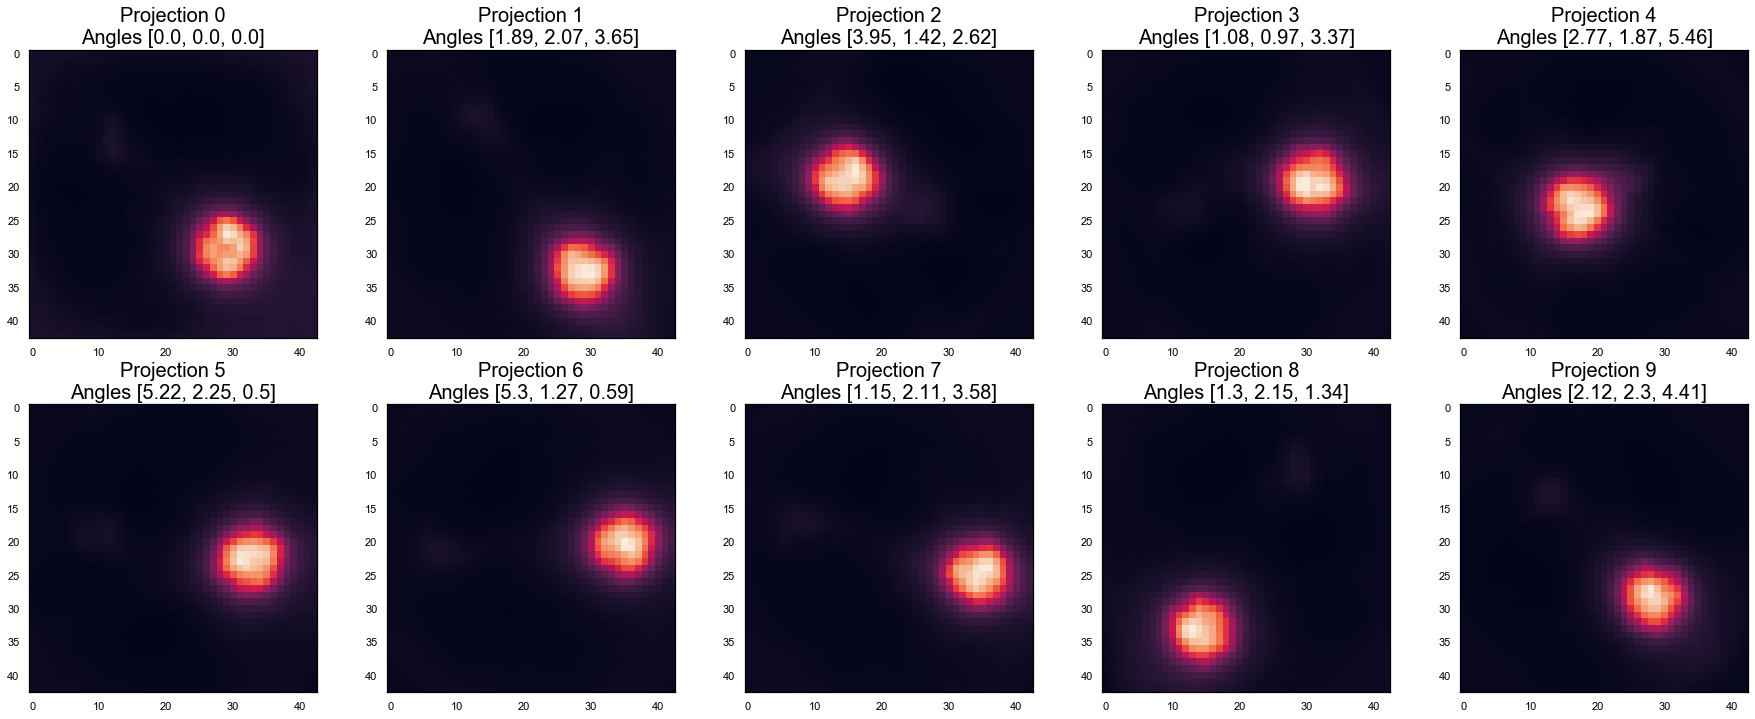

The 151-th iteration


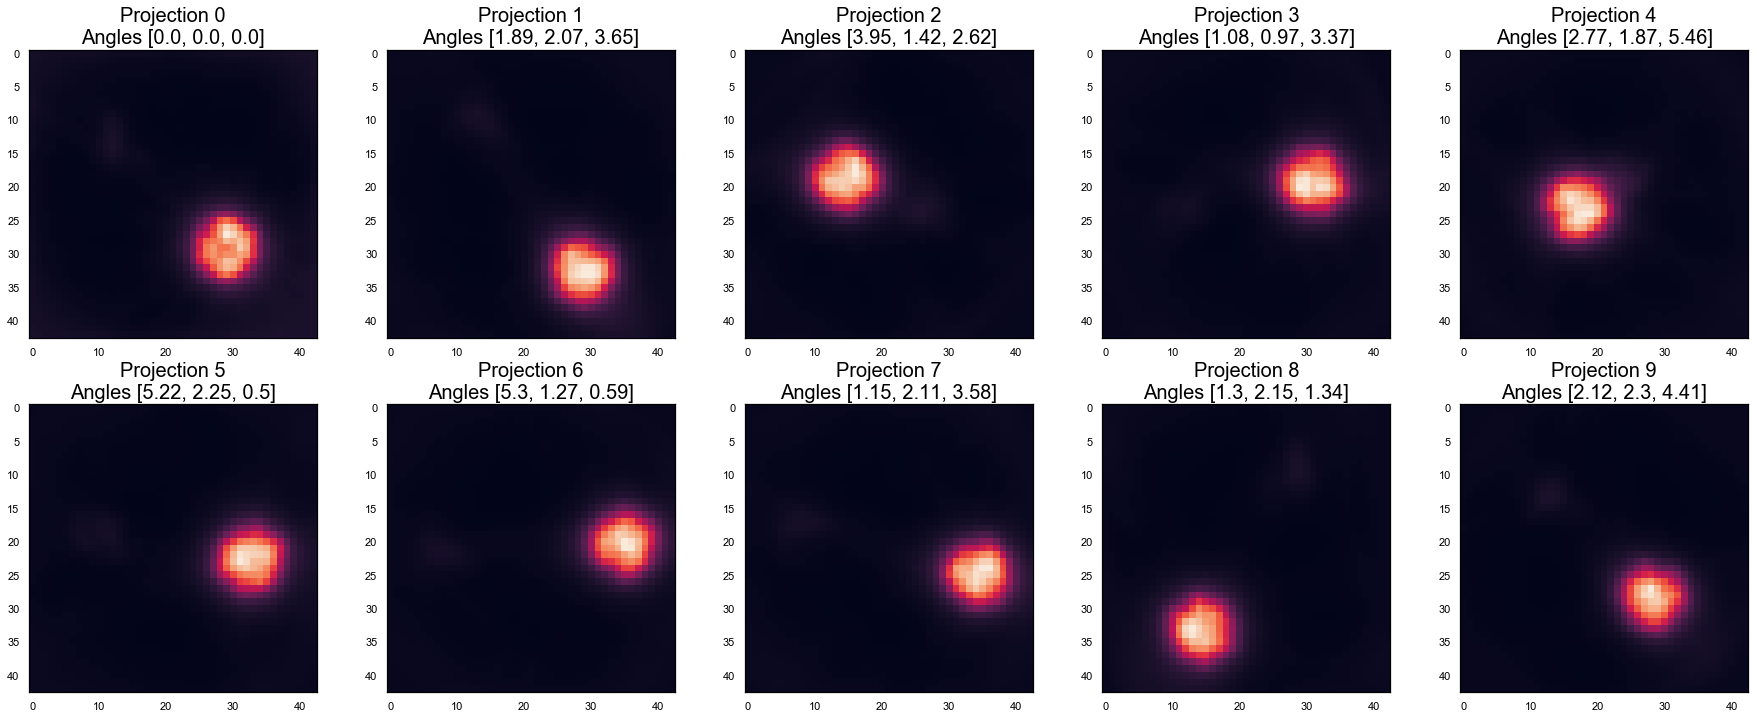

The 201-th iteration


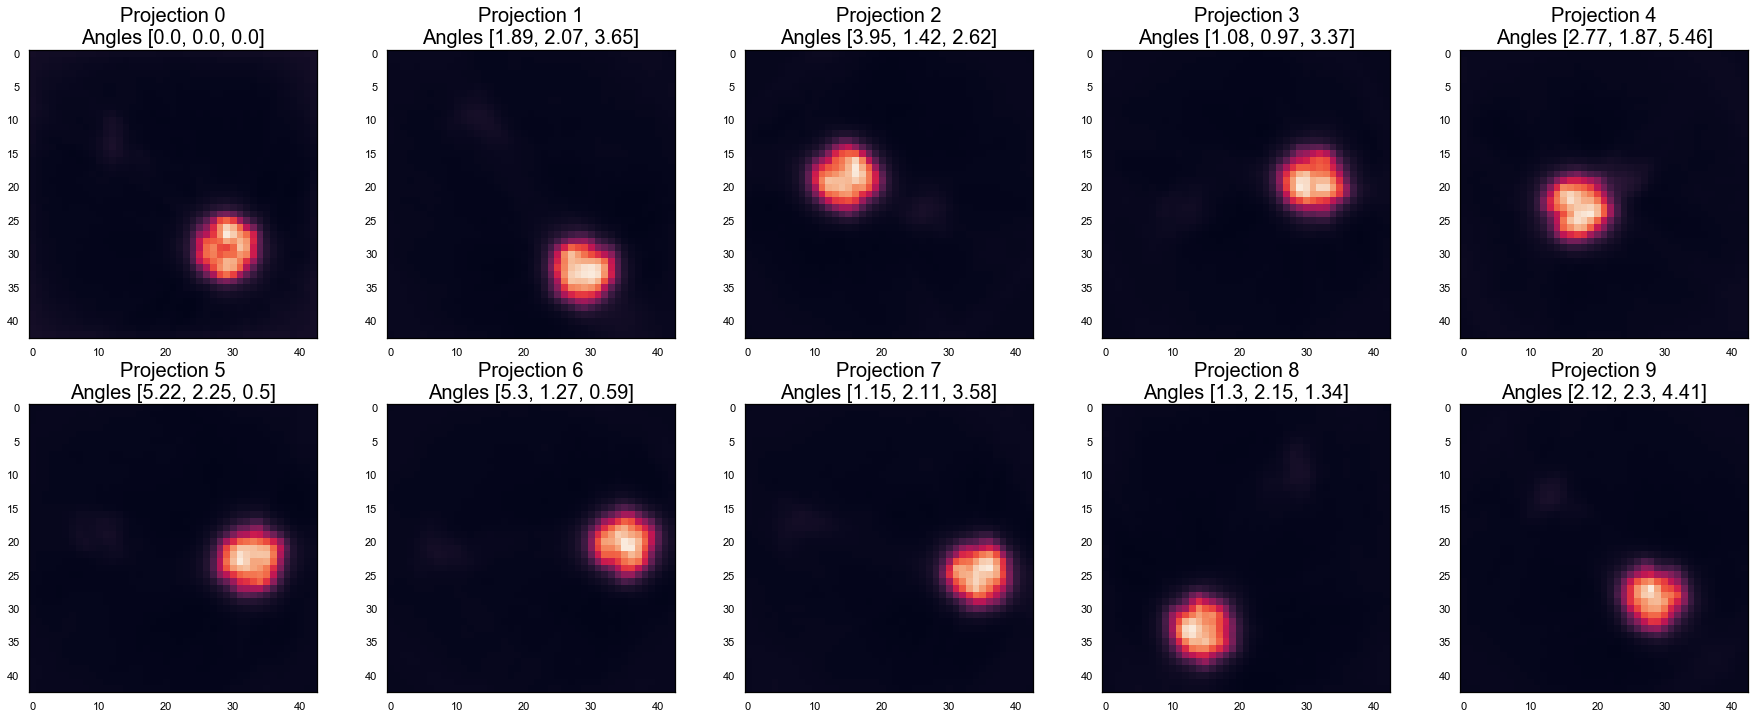

In [17]:



_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)

P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)

In [18]:
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)


(43, 43, 43)
43
(5000, 1849, 2)
start fitting
The 0-th iteration
Q -326931734.87625116


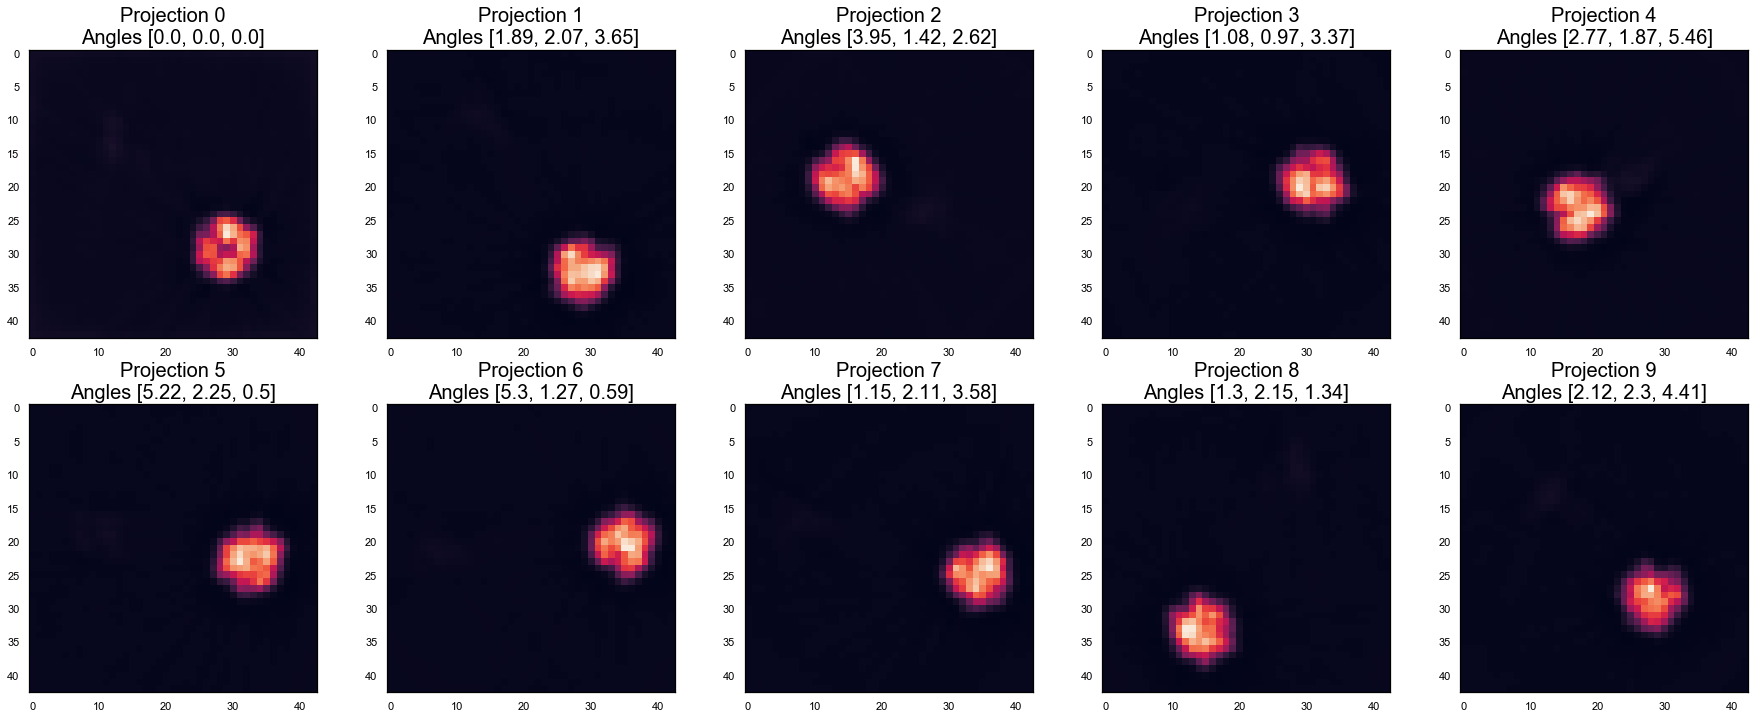

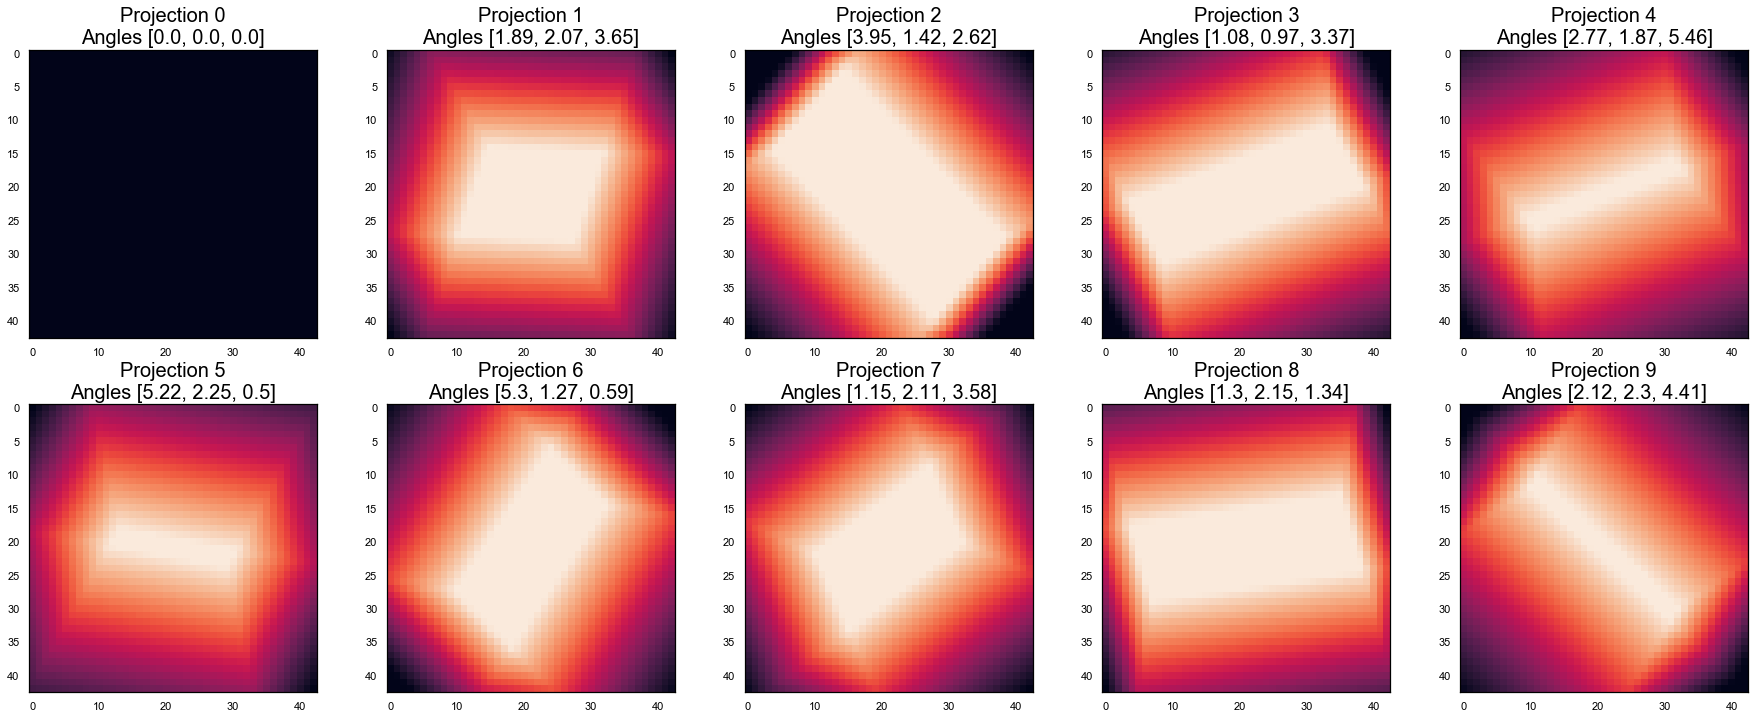

Q 6609084.132119049
delta Q 333540819.0083702
The 1-th iteration


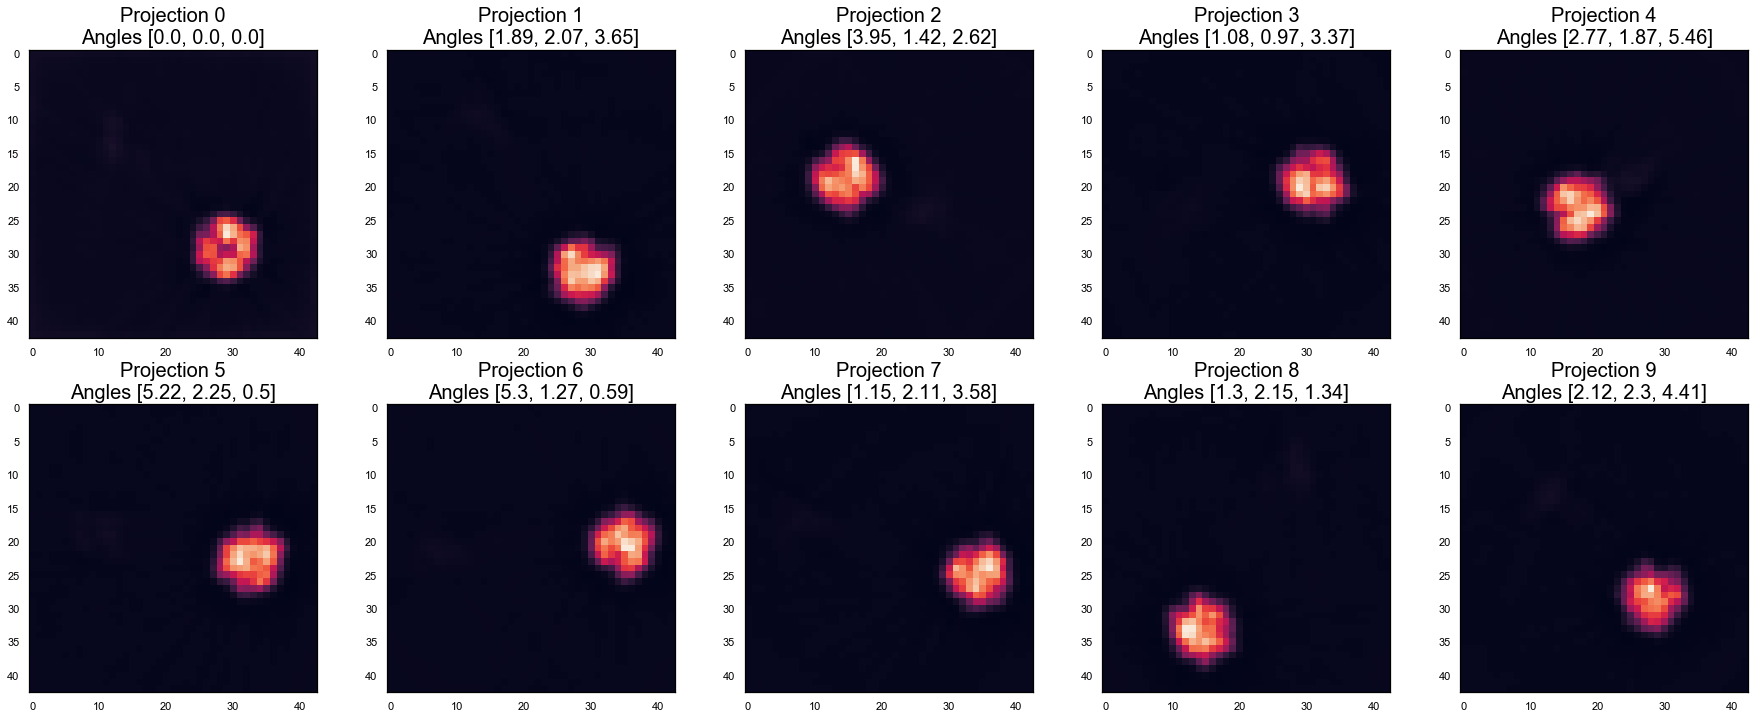

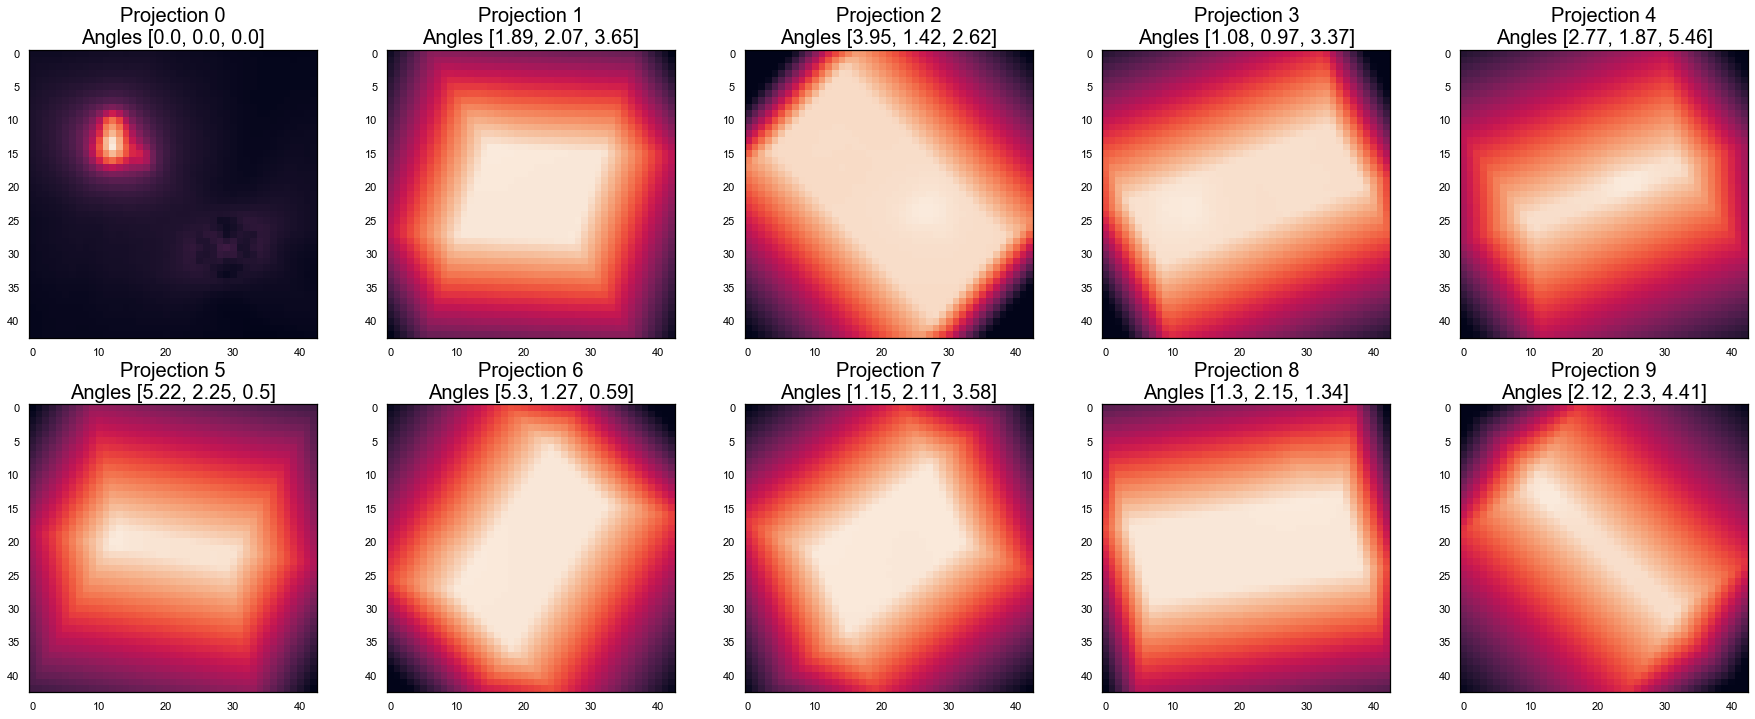

Q 6609084.132119049
delta Q 0.0
Q -1995970.876694354
delta Q -8605055.008813404
Q -2449779.2595763383
delta Q -453808.38288198435
Q -2920602.8882317897
delta Q -470823.62865545135
Q -3407671.4412297467
delta Q -487068.552997957
Q -3911084.059325398
delta Q -503412.61809565127
Q -4430970.89643245
delta Q -519886.8371070521
Q -4967512.345530738
delta Q -536541.4490982881
Q -5520941.160280361
delta Q -553428.8147496227
Q -6091546.183789815
delta Q -570605.023509454
Q -6679676.446920153
delta Q -588130.2631303379
Q -7285746.441130943
delta Q -606069.9942107899
Q -7910241.574089949
delta Q -624495.1329590064
Q -8553726.445135374
delta Q -643484.8710454246
Q -9216851.85360176
delta Q -663125.4084663857
Q -9900367.46913238
delta Q -683515.6155306213
Q -10605133.791351488
delta Q -704766.3222191073
Q -11332136.581925252
delta Q -727002.7905737646
Q -12082507.250084616
delta Q -750370.6681593638
Q -12857545.567433743
delta Q -775038.3173491266
Q -13658746.675386243
delta Q -801201.1079524998
Q 

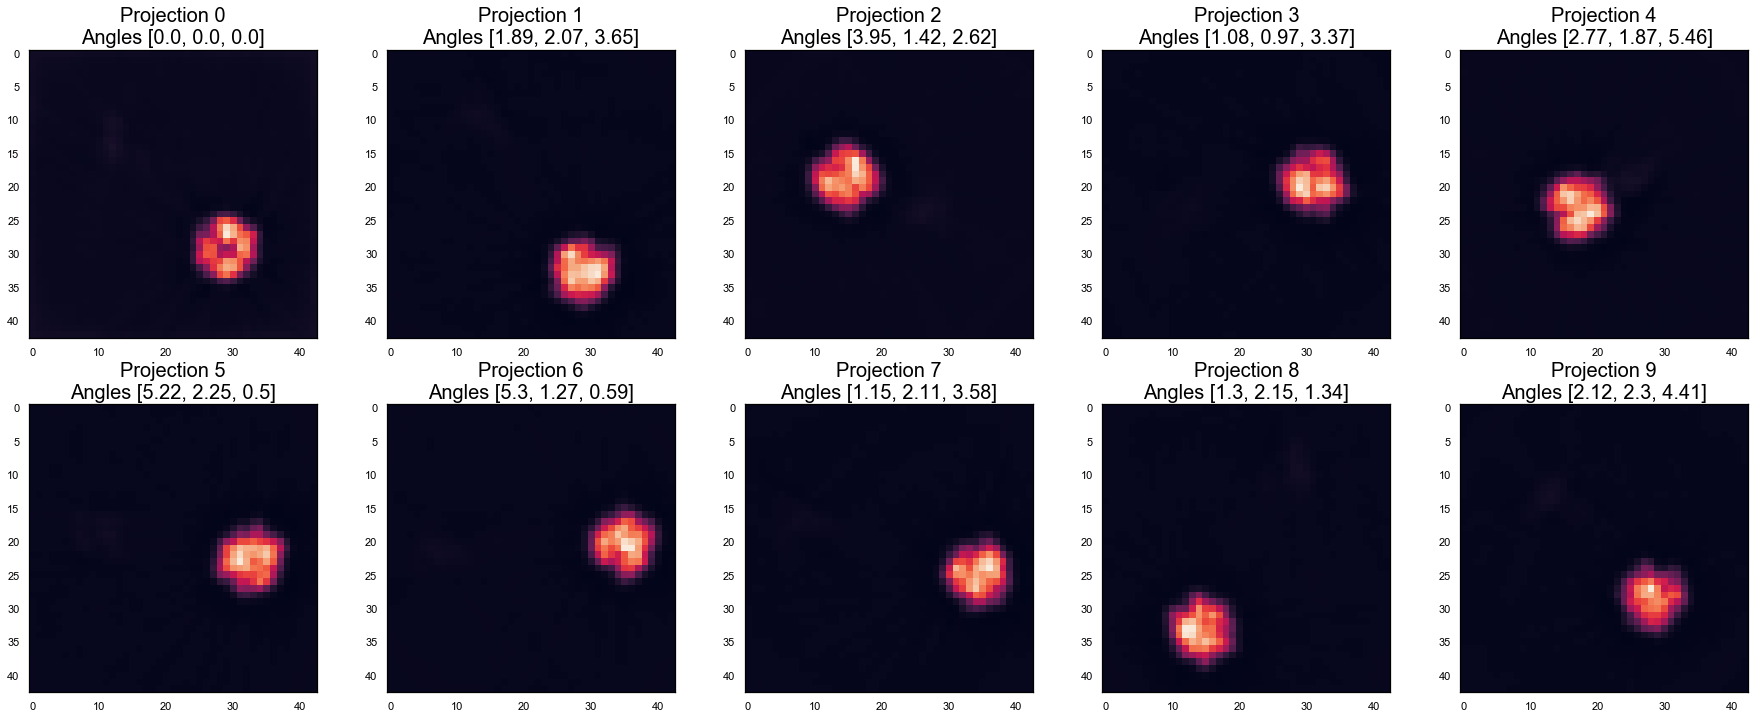

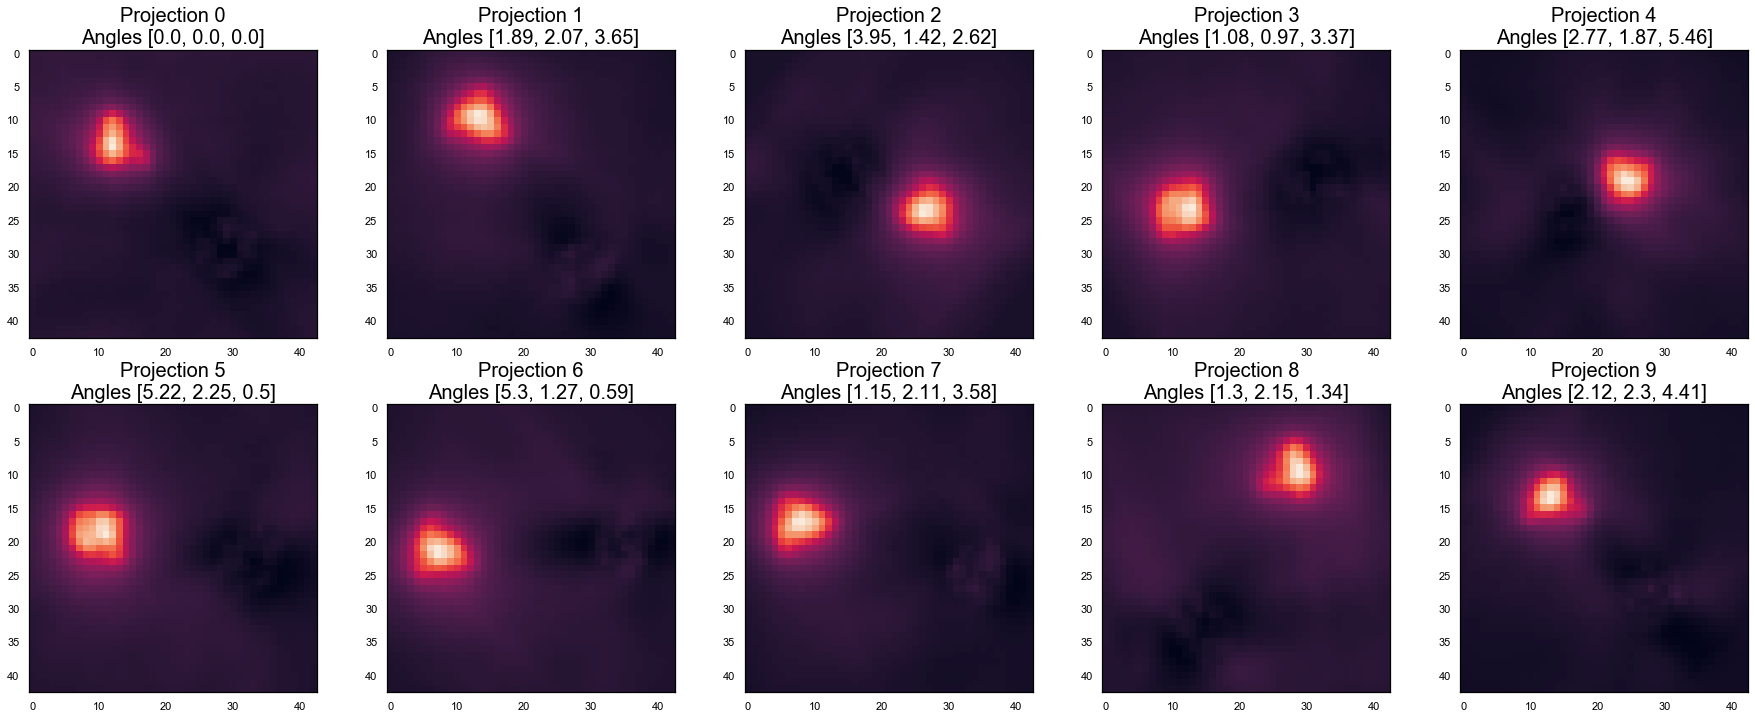

Q -82894264.07538031
delta Q 0.0
Q -84715512.22957745
delta Q -1821248.1541971415
Q -86499791.75218885
delta Q -1784279.5226113945
Q -88252482.78151803
delta Q -1752691.0293291807
Q -89978028.02568568
delta Q -1725545.2441676557
Q -91680154.15675898
delta Q -1702126.131073296
Q -93362029.02167986
delta Q -1681874.8649208844
Q -95026379.74271697
delta Q -1664350.7210371047
Q -96675574.46194215
delta Q -1649194.7192251831
Q -98311691.38280705
delta Q -1636116.920864895
Q -99936571.42621711
delta Q -1624880.0434100628
Q -101551854.84277901
delta Q -1615283.4165619016
Q -103159015.51417224
delta Q -1607160.6713932306
Q -104759388.05059043
delta Q -1600372.5364181846
Q -106354183.75691895
delta Q -1594795.7063285261
Q -107944515.26366074
delta Q -1590331.506741792
Q -109531405.92012283
delta Q -1586890.6564620882
Q -111115801.42693456
delta Q -1584395.506811723
Q -112698583.44361123
delta Q -1582782.0166766793
Q -114280573.34980911
delta Q -1581989.9061978757
Q -115862542.26107906
delta Q -

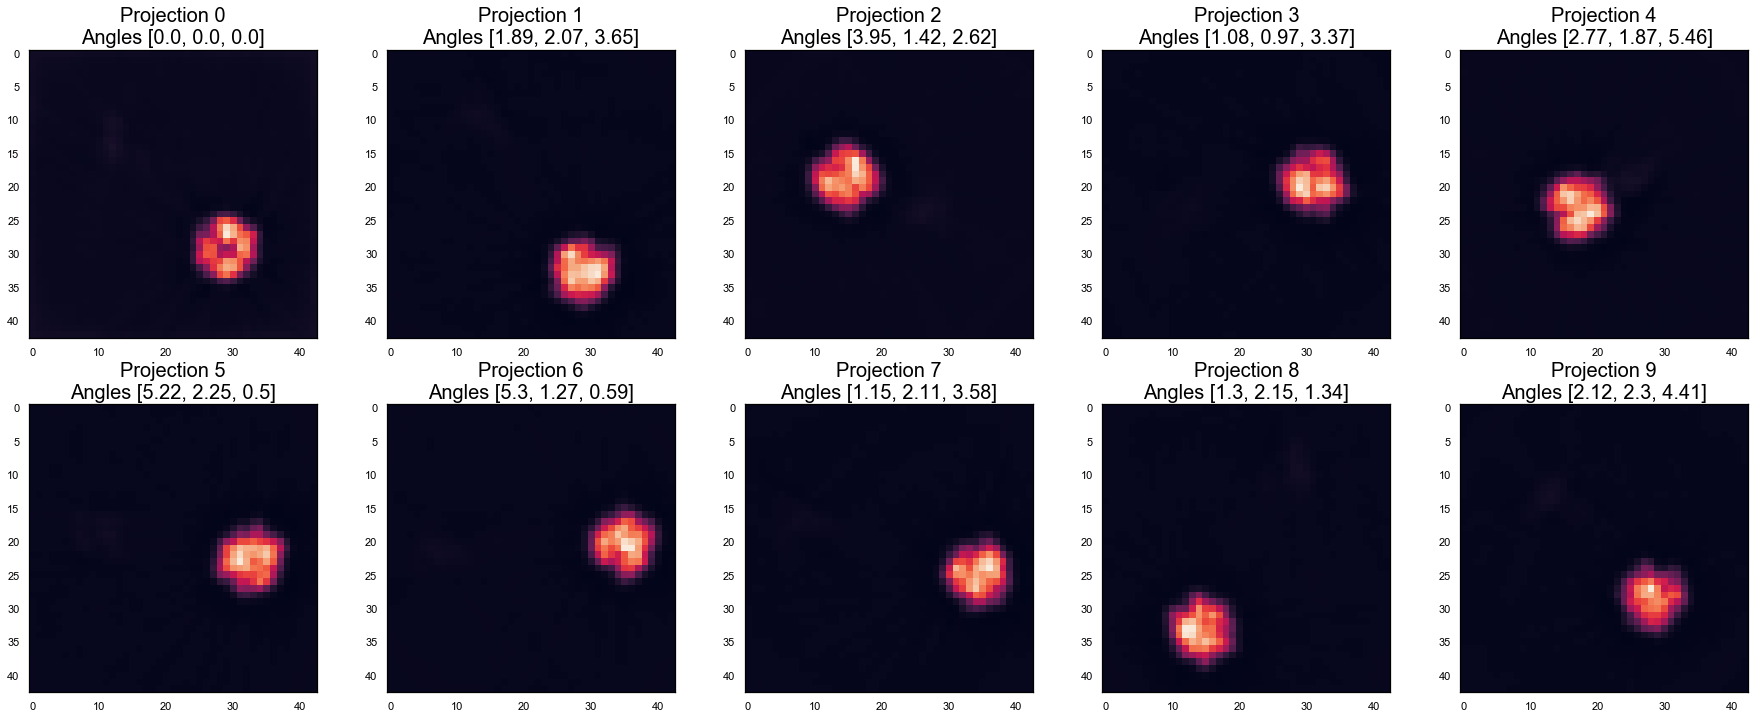

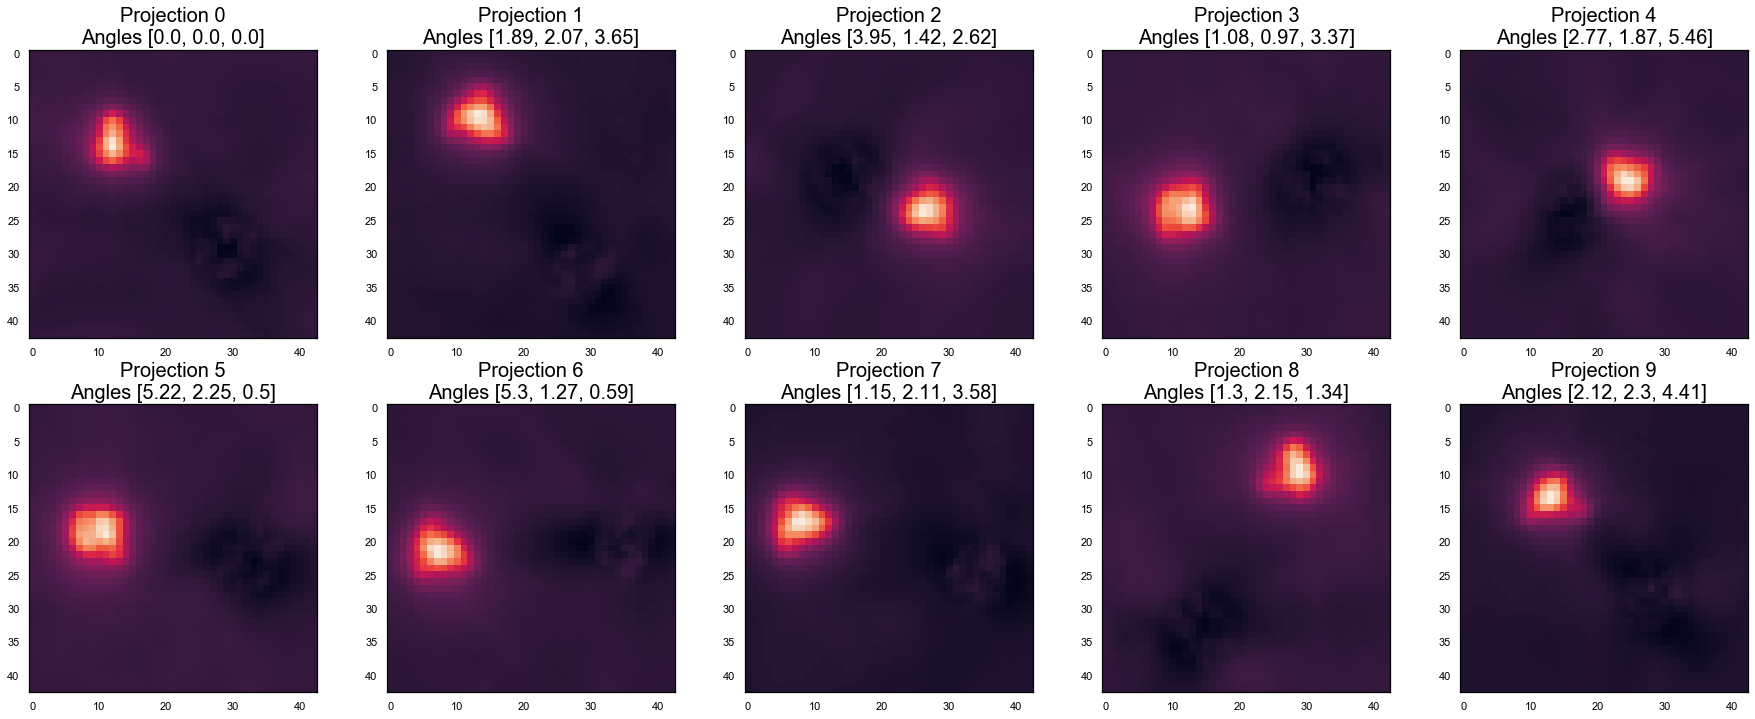

Q -166106490.73632792
delta Q 0.0
Q -167950951.7604058
delta Q -1844461.0240778923
Q -169810899.85092
delta Q -1859948.090514183
Q -171686754.6563279
delta Q -1875854.8054079115
Q -173578935.27203253
delta Q -1892180.6157046258
Q -175487860.5036958
delta Q -1908925.231663257
Q -177413951.76445144
delta Q -1926091.2607556581
Q -179357629.52372995
delta Q -1943677.759278506
Q -181319313.0574149
delta Q -1961683.5336849391
Q -183299428.6373356
delta Q -1980115.5799207091
Q -185298396.01817265
delta Q -1998967.380837053
Q -187316634.47766784
delta Q -2018238.4594951868
Q -189354568.05359885
delta Q -2037933.5759310126
Q -191412611.26072308
delta Q -2058043.2071242332
Q -193491187.82040733
delta Q -2078576.5596842468
Q -195590711.36519155
delta Q -2099523.544784218
Q -197711594.17241287
delta Q -2120882.8072213233
Q -199854247.90432456
delta Q -2142653.731911689
Q -202019075.0037919
delta Q -2164827.099467337
Q -204206481.22841525
delta Q -2187406.2246233523
Q -206416858.0354505
delta Q -22

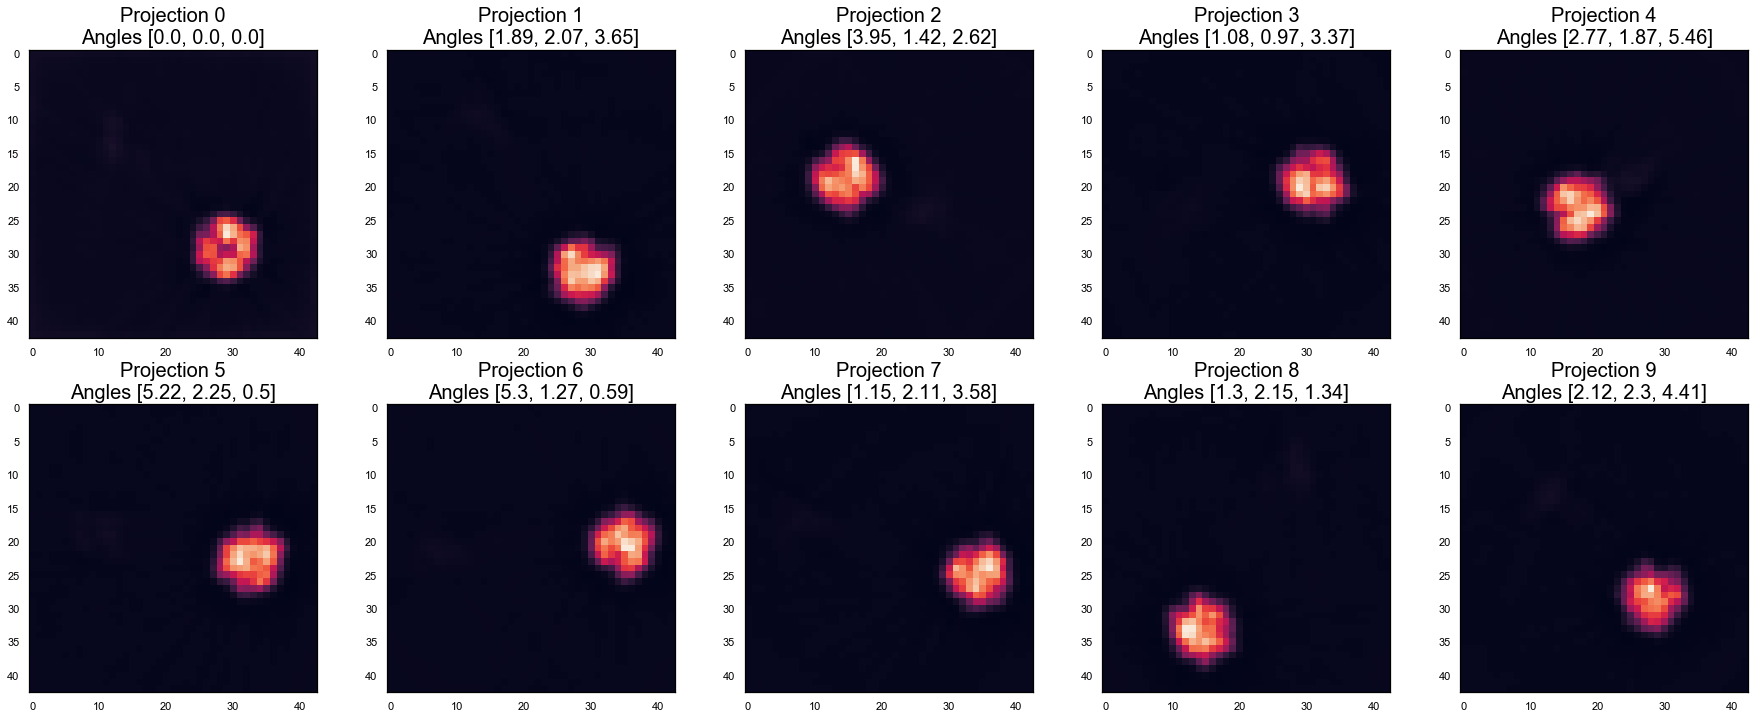

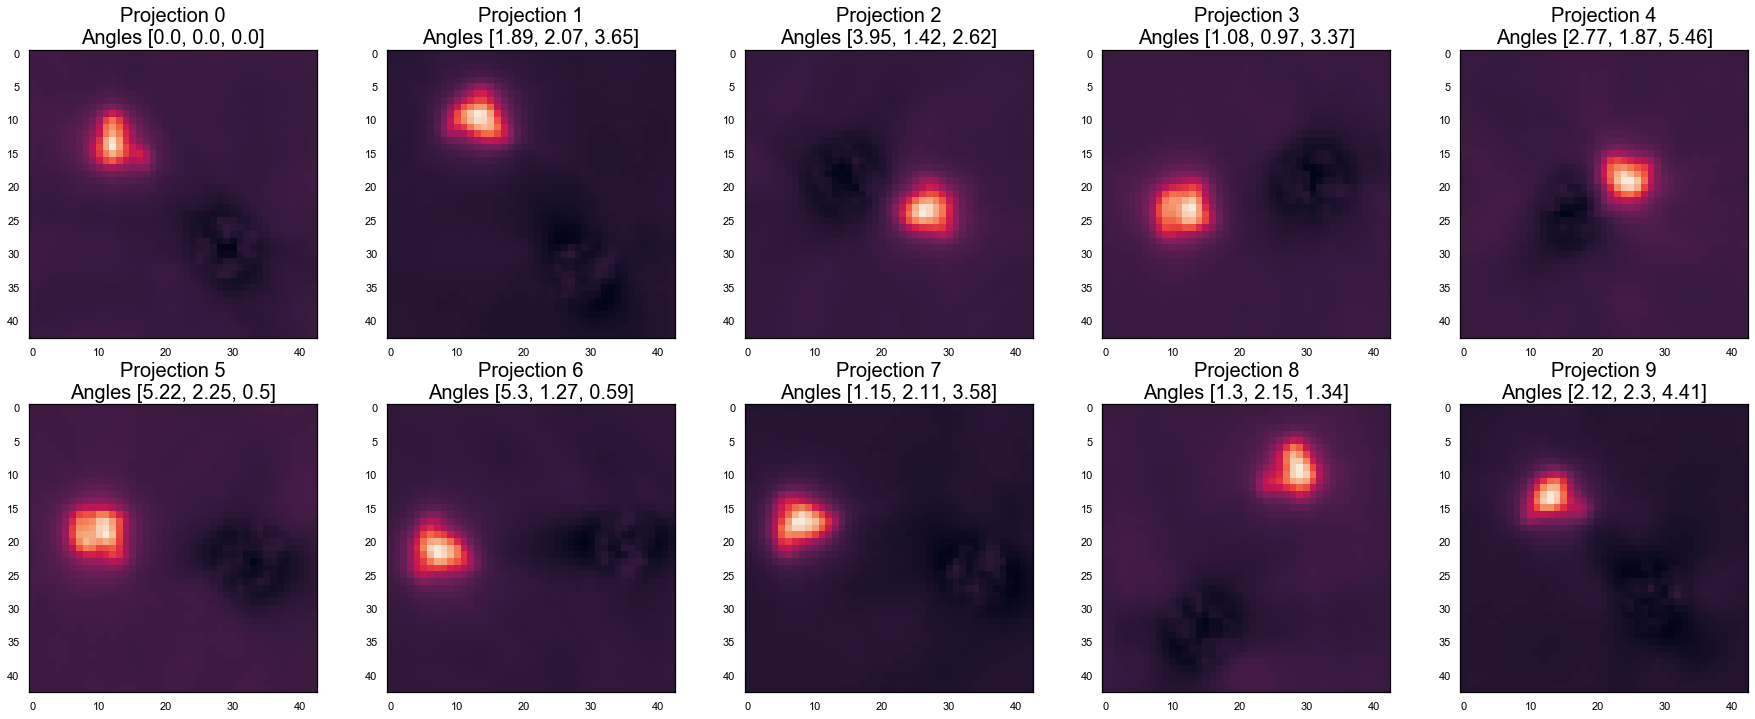

Q -284830131.1740612
delta Q 0.0
Q -287864535.9267088
delta Q -3034404.7526476383
Q -290924501.45268446
delta Q -3059965.5259756446
Q -294009570.7463025
delta Q -3085069.2936180234
Q -297119248.69491094
delta Q -3109677.948608458
Q -300253006.4134532
delta Q -3133757.718542278
Q -303410271.72303194
delta Q -3157265.3095787168
Q -306590435.95190334
delta Q -3180164.228871405
Q -309792853.0362549
delta Q -3202417.0843515396
Q -313016841.49662733
delta Q -3223988.460372448
Q -316261687.61765814
delta Q -3244846.1210308075
Q -319526641.6461741
delta Q -3264954.028515935
Q -322810921.6672924
delta Q -3284280.021118343
Q -326113721.69761103
delta Q -3302800.030318618
Q -329434202.6428207
delta Q -3320480.945209682
Q -332771496.06370825
delta Q -3337293.42088753
Q -336124719.75078535
delta Q -3353223.687077105
Q -339492959.81591046
delta Q -3368240.0651251078
Q -342875289.4277249
delta Q -3382329.6118144393
Q -346270756.51610917
delta Q -3395467.0883842707
Q -349678404.7656807
delta Q -340764

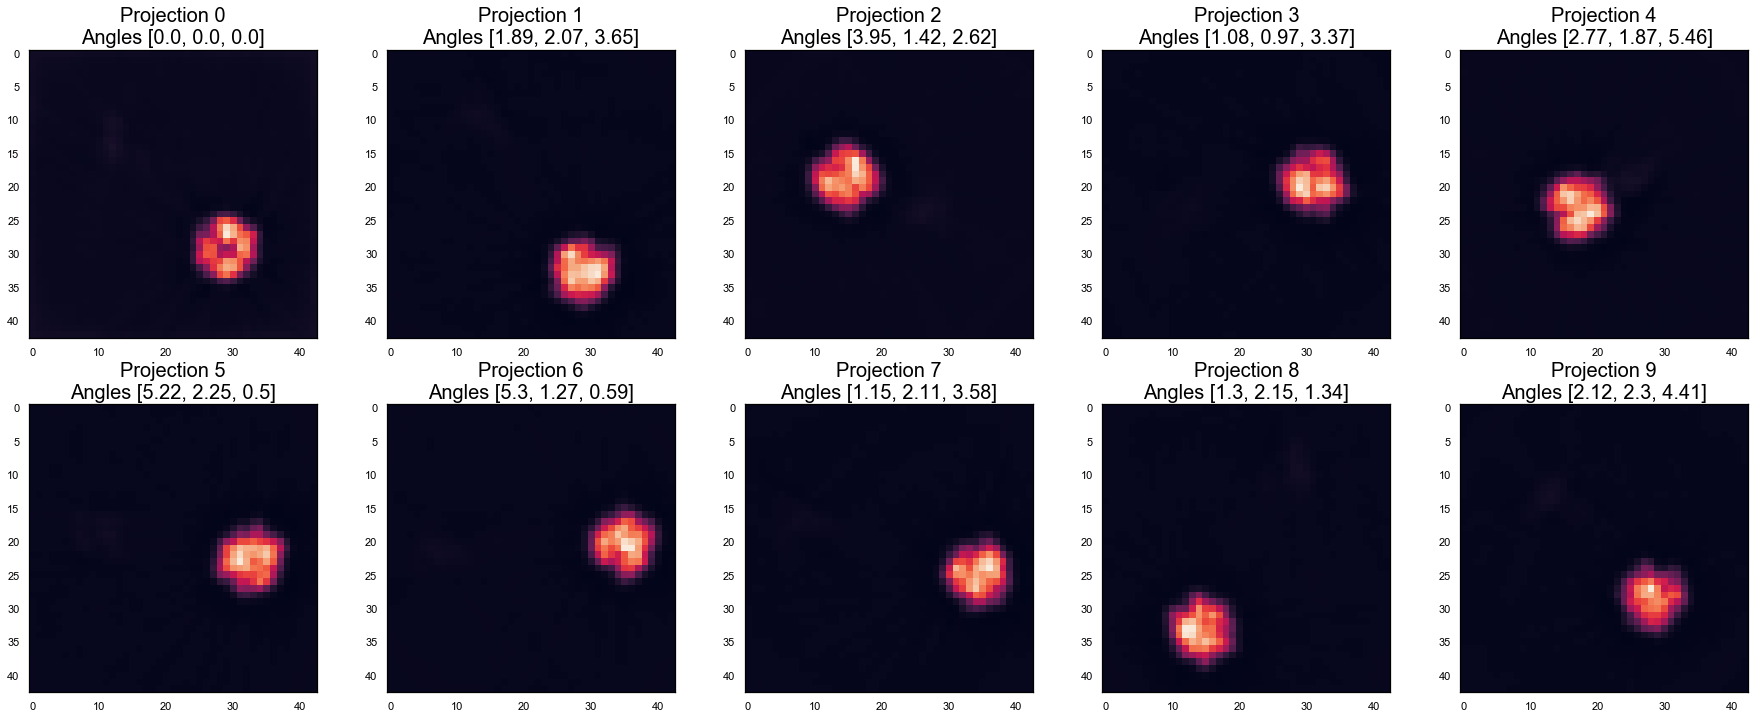

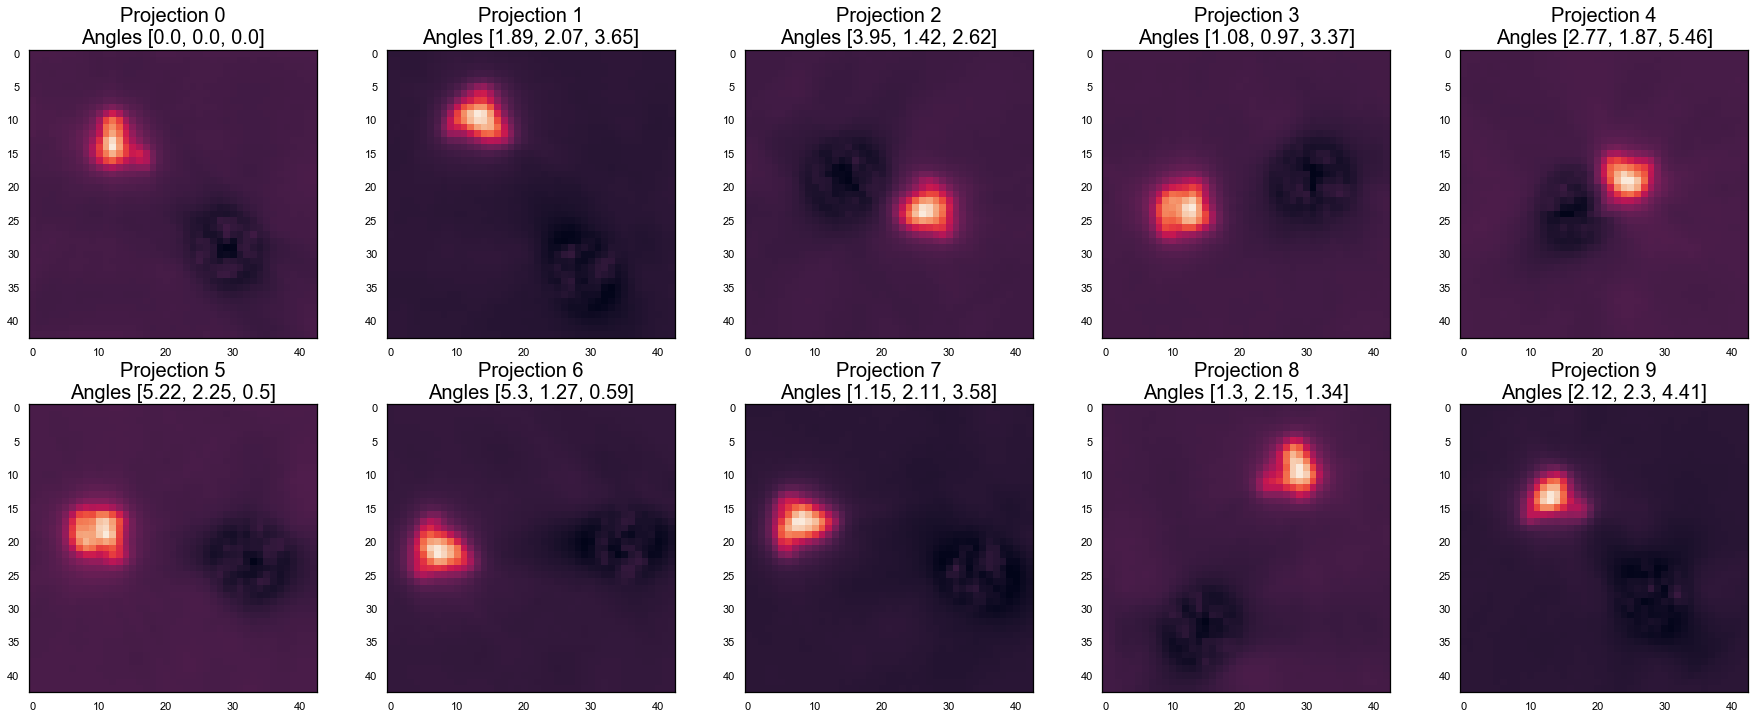

Q -452777231.4010063
delta Q 0.0
Q -456099041.1889199
delta Q -3321809.7879136205
Q -459405929.8605325
delta Q -3306888.6716126204
Q -462697388.00759184
delta Q -3291458.1470593214


In [ ]:
_, num_image , n_component = 116, 5000 , 2
print(P3R.mu.shape)
print(ProjSize1)
Mus = P3R.mu.reshape(1, ProjSize1, ProjSize1, ProjSize1)
P3RM = PCA_3d_Recon_recurssive(ProjSize1, num_image, n_component,Mus )
P3RM.Au_s(angles2)
print(P3RM.Aus.shape)
#P3RM.Plot_mu_by_projection(angles2)
#P3RM.Expectation(new_projection , angles2)
#P3RM.Maximization(new_projection , angles2)
P3RM.fit(new_projection , angles2)

In [ ]:
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)

In [ ]:
#Check ro_j whether the same

print(True_z2.reshape(-1)[:5])
print(P3RM.ro[:5,0])
print(True_z1.reshape(-1)[:5])
print(P3RM.ro[:5,1])

print(P3RM.Mus.shape)
vec1 = P3RM.Mus[0].reshape(-1)
vec2 = P3RM.Mus[1].reshape(-1)
print(np.sum(vec1*vec2))
print(np.dot(vec1 ,vec1) /np.linalg.norm(vec1) / np.linalg.norm(vec1))
print(np.sum(vec1*vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

In [ ]:
print(np.linalg.norm(Vol2))
print(np.linalg.norm(Vol1))
print(np.linalg.norm(P3R.mu))

In [ ]:
#print(P3R.mu)
ProjSize = ProjSize1
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print('the 2th component')
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
print(curremt_mu.shape)
print('P3RM.Mus[-1]',np.mean(P3RM.Mus[-1]))
print('+P3RM.Mus[0]', np.mean(P3RM.Mus[0]))
print(np.sum(np.abs(P3RM.Mus[-1]+P3RM.Mus[0])))

In [ ]:
curremt_mu = P3RM.Mus[0].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(-CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)